#### Mohamed HAJJI 


## Porblème de Démineur

Le démineur est un jeu de réflexion dont le but est de localiser des mines cachées dans un champ virtuel avec pour seule indication le nombre de mines dans les zones adjacentes.

Notre But ici est de localiser les mines dans une matrice de taille $n\times n $ avec comme indication dans chaque case, le nombre de mines dans les zones adjacentes, en utilsant l'algorithe de de Metropolis. 

In [2]:
#import des packages 
library(gridExtra) 
library(grid)

In [3]:
## Generation de la table que l'on va devoir deviner
## nombre de cases
nbcolonnes=10
nblignes=10
N = nblignes*nbcolonnes #grille nblignes x nbcolonnes
Gcorrec <- array(0,dim=c(nblignes,nbcolonnes)) 

# nombre de mines
nbmine=15

# On définit aleatoirement les coordonnees sur lesquelles il y aura des mines
Gmine=(sample(1:N,nbmine,replace=F))
Gcorrec[Gmine]=1

#### Affichage des mines à trouver

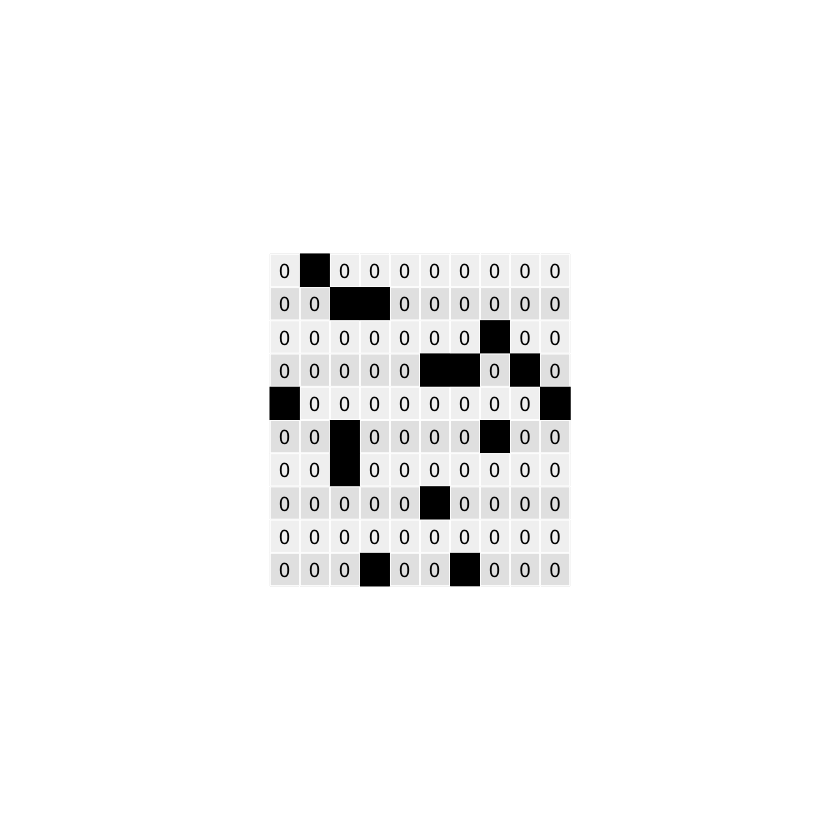

In [4]:
grid.table(Gcorrec)

g <- tableGrob(Gcorrec)
for (i in 1:nbmine) {
  g$grobs[N+Gmine[i]][[1]][["gp"]] <- gpar(fill="black", col = "black", lwd=15)
  grid.draw(g)
}

In [5]:
#ces fonctions renvoient la coordonnée de N a laquelle correspond la case indiqué 
coord_hautgauche  = function(case) case-nblignes-1
coord_gauche      = function(case) case-nblignes
coord_hautdroite  = function(case) case+nblignes-1
coord_droite      = function(case) case+nblignes
coord_haut        = function(case) case-1
coord_basgauche   = function(case) case-nblignes+1
coord_bas         = function(case) case+1
coord_basdroite   = function(case) case+nblignes+1

#Ces fonctions renvoient les conditions pour obtenir coordonnees indiquées
cond_haut         = function(case) coord_haut(case) %% nblignes != 0
cond_bas          = function(case) coord_bas(case) %% nblignes != 1
cond_droite       = function(case) coord_droite(case) <= N
cond_gauche       = function(case) coord_gauche(case) > 0

In [6]:
## Création de la Matrice de voisinage (Voisin) # renvoie 1 pour chaque cases voisine
Voisin <- array(0,dim=c(N,N))

for (i in 1:N) {
  if(cond_haut(i))           Voisin[i,coord_haut(i)]     = 1
  
  if(cond_bas(i))            Voisin[i,coord_bas(i)]      = 1
                              
  if(cond_gauche(i))         Voisin[i,coord_gauche(i)]   = 1
                              
  if(cond_droite(i))         Voisin[i,coord_droite(i)]   = 1
                              
  if(cond_haut(i) && cond_gauche(i))  Voisin[i,coord_hautgauche(i)] = 1
                                       
  if(cond_haut(i) && cond_droite(i))  Voisin[i,coord_hautdroite(i)] = 1
 
  if(cond_bas(i) && cond_gauche(i))   Voisin[i,coord_basgauche(i)]  = 1

  if(cond_bas(i) && cond_droite(i))   Voisin[i,coord_basdroite(i)]  = 1
                                      
}

Création de la matrice d'information $Info$  qui indique le nombre de mines au voisinage de chaque cases

In [7]:
Info <- array(0,dim=c(nblignes,nbcolonnes))

for (i in Gmine) {
  Info[which(Voisin[i,]==1)]=1 + Info[which(Voisin[i,]==1)]
}

#### Affichage de la grille d'information, créée à partir des mines posées aléatoirement

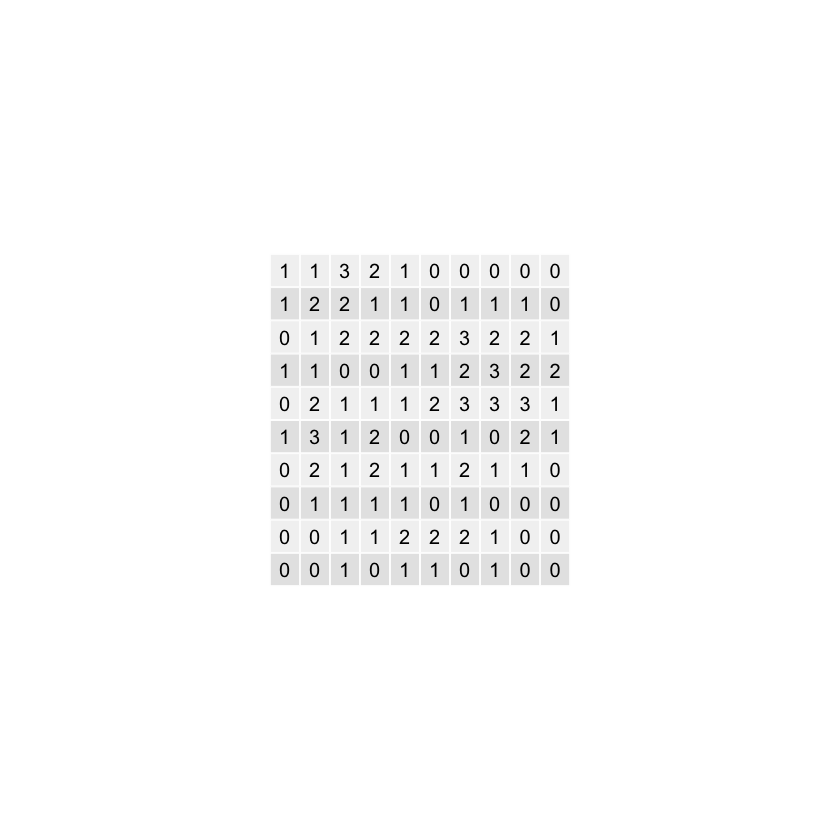

In [8]:
grid.table(Info)

#### Fonction de calcul du nombre de cases ayants une anomalies sur la grille

In [9]:
anomalies=function(G) {
  result=0
for (i in 1:N) {
    result=result+(Info[i] != sum(G*Voisin[i,]))*1
    }
return(result)
}

### Ecriture des fonctions de transition:

#### Algorithme de Metropolis

In [10]:
transition1 = function(g,beta) {
  result=g
  gnew=g
  k0=sample(1:N,1)
  gnew[k0]=sample(c(max(g[k0]-1,0),min(g[k0]+1,1)),1)
  delta=0
  diffcases=0
  for (i in which(Voisin[k0,] == 1)) {
    delta=delta +  abs((sum(gnew*Voisin[i,]))-Info[i]) - abs((sum(g*Voisin[i,]))-Info[i])
  }
  # On regarde si, pour chaque voisins de k0, l'operation executé en k0 (c'est a dire, on rajoute ou retire une mine)
  # nous rapproche de la matrice d'information que l'on veut obtenir, on regarde non pas la différence entre 
  # le nombre de mauvaise cases mais la différence d'anomalies par rapport à la matrice d'information
  alpha=min(exp(-beta*delta),1)
  u=runif(1)
  if(u<alpha){
    result=gnew}
  return(result)
}

In [11]:
transition1bis = function(g,beta) {
  result=g
  gnew=g
  k0=sample(1:N,1)
  gnew[k0]=sample(c(max(g[k0]-1,0),min(g[k0]+1,1)),1)
  delta=0
  diffcases=0
    delta=anomalies(gnew)-anomalies(g) #on regarde le nombre de cases indiquants de mauvaises informations avant et après changement
  alpha=min(exp(-beta*delta),1)
  u=runif(1)
  if(u<alpha){
    result=gnew}
  return(result)
}

#### Méthode de Gibbs

In [12]:
transition2 = function(g,beta) {
  result=g
  gnew=g
  k0=sample(1:N,1)
  Num=rep(1,2)
  for (j in 1:2) {
    g[k0]=j-1
    for (i in which(Voisin[k0,] == 1)) {
      Num[j]=Num[j] * exp(-beta*(abs(sum(g*Voisin[i,])-Info[i])))    
    }
  }
  PGibbs=Num/sum(Num)
  gnew[k0]=sample(c(0,1),1,prob=PGibbs)
  delta=0
  for (i in which(Voisin[k0,] == 1)) {
  delta=delta +  abs((sum(gnew*Voisin[i,]))-Info[i]) - abs((sum(g*Voisin[i,]))-Info[i])
  #delta=sum(abs(gnew[k0]==gnew)*V[k0,])-sum(abs(g[k0]==g)*V[k0,])
  }
  #alpha=min(exp(beta*delta),1)
  result=gnew
  return(result)
}

### Calcul de l'évolution de $H$ Pour chaques fonctions de transition

#### Calcul de $H$  avec transition 1 : (10000 transitions avec recuit) 

In [13]:
nmax=20000
beta=1
beta0=0.2

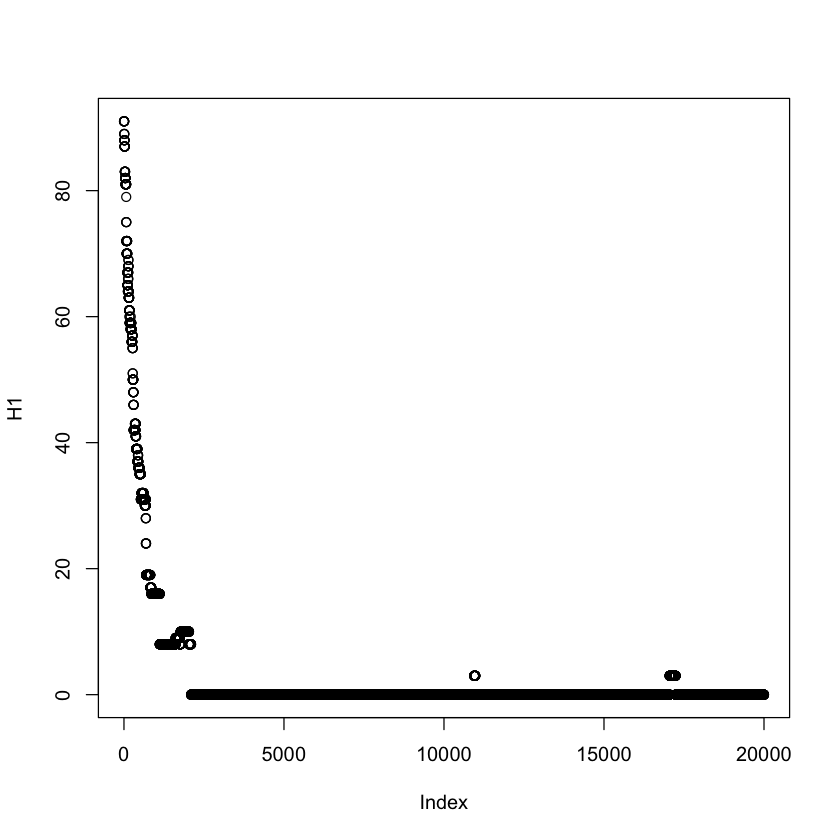

In [14]:
G <- sample(0:1,N,replace=T)
H1=rep(0,nmax)
H1[1]=anomalies(G)
Gbest=G
Hbest=H1[1]
for (i in 1:(nmax-1)){
  beta=beta0*log(i)
  trans1=transition1(G,beta)
  H1[i+1]=anomalies(G)
  G=trans1[1:N]
  if (H1[i+1]<Hbest) {
    Hbest=H1[i+1]
    Gbest=G
  }
}
plot(H1)

#### Calcul de $H$ avec transition 1bis: (10000 transitions avec recuit) 

In [ ]:
G <- sample(0:1,N,replace=T)
H1bis=rep(0,nmax)
H1bis[1]=anomalies(G)
Gbest=G
Hbest=H1bis[1]
for (i in 1:(20000-1)){
  beta=beta0*log(i)
  trans1=transition1bis(G,beta)
  H1bis[i+1]=anomalies(G)
  G=trans1[1:N]
  if (H1bis[i+1]<Hbest) {
    Hbest=H1bis[i+1]
    Gbest=G
  }
}
plot(H1bis)

#### Calcul de $H$ avec transition 2  : (10000 transitions avec recuit) 

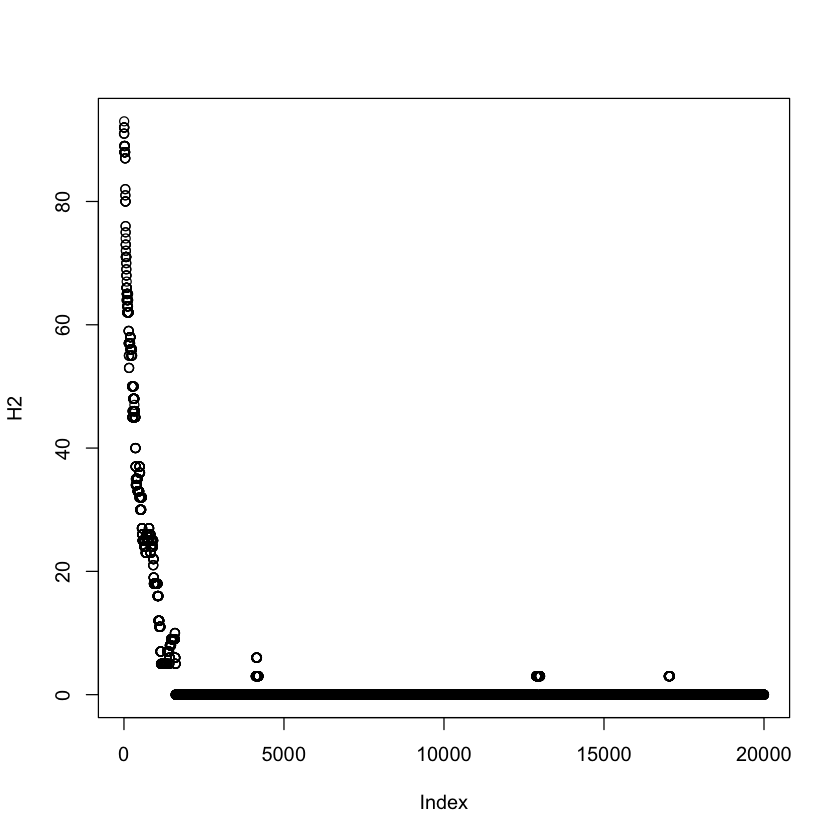

In [17]:
G <- sample(0:1,N,replace=T)
H2=rep(0,nmax)
H2[1]=anomalies(G)
Gbest=G
Hbest=H2[1]
for (i in 1:(nmax-1)){
  beta=beta0*log(i)
  trans2=transition2(G,beta)
  H2[i+1]=anomalies(G)
  G=trans2[1:N]
  if (H2[i+1]<Hbest) {
    Hbest=H2[i+1]
    Gbest=G
  }
}
plot(H2)

### Affichage des mines trouvées avec la matrice d'information

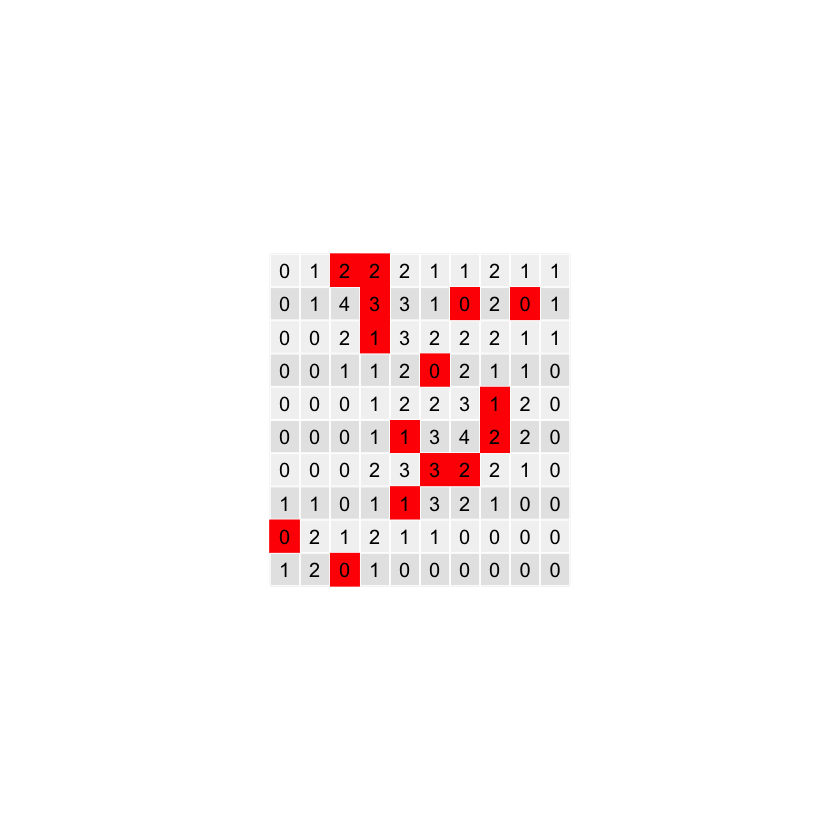

In [18]:
Gminetrv=(which(G == 1))
nbminetrv=sum(G)
G<- array(G,dim=c(nblignes,nbcolonnes))

#représentation des mines trouvées 
grid.table(Info)

g <- tableGrob(Info)
for (i in 1:nbminetrv) {
  g$grobs[N+Gminetrv[i]][[1]][["gp"]] <- gpar(fill="red", col = "red", lwd=5)
  grid.draw(g)
}

In [19]:
G<- array(G,dim=c(nblignes,nbcolonnes))

In [20]:
G

0,0,1,1,0,0,0,0,0,0
0,0,0,1,0,0,1,0,1,0
0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,0,1,0,0
0,0,0,0,1,0,0,1,0,0
0,0,0,0,0,1,1,0,0,0
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0


In [21]:
Gcorrec

0,0,1,1,0,0,0,0,0,0
0,0,0,1,0,0,1,0,1,0
0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,0,1,0,0
0,0,0,0,1,0,0,1,0,0
0,0,0,0,0,1,1,0,0,0
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0
